In [15]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import torch
import cv2
import numpy as np
from models.siamese.siamese_model import SiameseNetwork
from utils.loss import ContrastiveLoss
import matplotlib.pyplot as plt

In [20]:
def load_image(image_path):
    """Đọc và tiền xử lý ảnh từ file, trả về tensor và ảnh gốc."""
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Cannot load image at {image_path}")
    img_normalized = img.astype(np.float32) / 255.0  # Normalize 0-1
    img_tensor = torch.tensor(img_normalized, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # [1, 1, H, W]
    return img_tensor, img

def test_model(image1_path, image2_path, checkpoint_path, threshold, device, margin, real_label):
    """Kiểm tra mô hình trên một cặp ảnh và hiển thị kết quả."""
    model = SiameseNetwork().to(device)
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    # Load ảnh và giữ ảnh gốc để hiển thị
    img1_tensor, img1_display = load_image(image1_path)
    img2_tensor, img2_display = load_image(image2_path)
    img1_tensor = img1_tensor.to(device)
    img2_tensor = img2_tensor.to(device)

    with torch.no_grad():
        output1, output2 = model(img1_tensor, img2_tensor)
        diff = torch.sqrt(torch.sum((output1 - output2) ** 2, dim=1))
        predicted = (diff <= threshold).float()
        prediction = "Similar" if predicted.item() == 1 else "Dissimilar"
        distance = diff.item()

    real_label_str = "Similar" if real_label == 1 else "Dissimilar"
    # Hiển thị ảnh và kết quả
    plt.figure(figsize=(10, 5))

    # Ảnh 1
    plt.subplot(1, 2, 1)
    plt.imshow(img1_display, cmap='gray')
    plt.title("Image 1")
    plt.axis('off')

    # Ảnh 2
    plt.subplot(1, 2, 2)
    plt.imshow(img2_display, cmap='gray')
    plt.title("Image 2")
    plt.axis('off')

    # Thêm text cho distance và prediction
    plt.suptitle(f"Distance: {distance:.4f}\nPrediction: {prediction}\nReal Label: {real_label_str}", 
                 fontsize=12, y=1.05)
    plt.tight_layout()
    plt.show()

    print(f"Distance: {distance:.4f}, Prediction: {prediction}, Real Label: {real_label_str}")
    return prediction

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [26]:
# Cấu hình
checkpoint_path = "../models/siamese/siamese_checkpoint_lr_0.0005_margin_1.0.pth"  
threshold = 0.5
margin = 1.0 


Testing pair: ../data/test_samples/char2/1.png vs ../data/test_samples/char2/2.png


C:\Users\admin\AppData\Local\Temp\ipykernel_15216\1345201030.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=devic

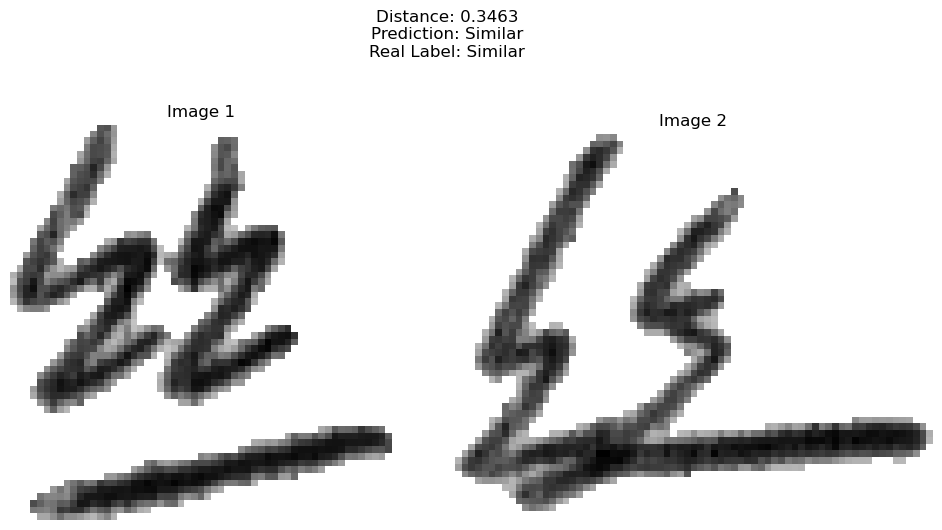

Distance: 0.3463, Prediction: Similar, Real Label: Similar


In [28]:
 image_pair = [
    '../data/test_samples/char2/1.png',  
    '../data/test_samples/char2/2.png'   
]
real_label = 1
if os.path.exists(image_pair[0]) and os.path.exists(image_pair[1]):
    print(f"\nTesting pair: {image_pair[0]} vs {image_pair[1]}")
    test_model(image_pair[0], image_pair[1], checkpoint_path, threshold, device, margin, real_label)
else:
    print("One or both images not found. Please check the paths.")